In [2]:
%load_ext autoreload
%autoreload 2

### 1. Load MIRIAD Dataset

In [3]:
import torchvision.transforms as transforms
from miriad import MiriadDataset
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

batch_size=1

train_dataset = MiriadDataset(root="data/miriad", train=True, transform=transform, crop=0.5)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dataset = MiriadDataset(root="data/miriad", train=False, transform=transform, crop=0.5)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('HC', 'AD')

train_dataset[0][0].size()

torch.Size([1, 62, 128, 128])

torch.Size([1, 1, 62, 128, 128])


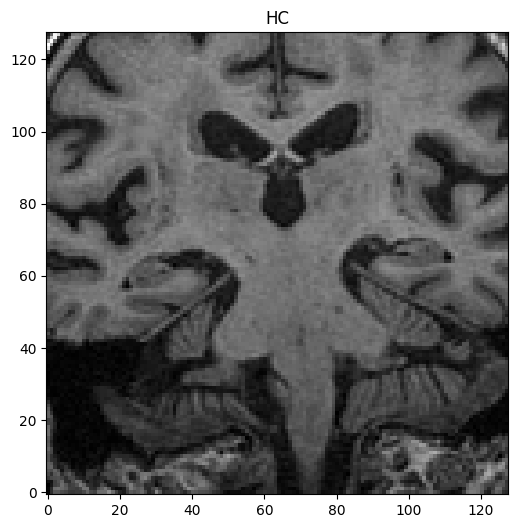

In [4]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(train_loader)
mris, labels = next(dataiter)

print(mris.size())

plt.figure(figsize=(12, 6))
i = 0
for sample_data, sample_label in zip(mris, labels):
    mri_sample_slice = sample_data[0, 32, :, :]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(mri_sample_slice.T, cmap='gray', origin='lower')
    plt.title(f"{classes[sample_label]}")  # Display the label as the title
    i += 1
plt.show()

### 2. Implement 3D-CNN Classification Model

In [19]:
from models import AlzheimersClassification3DCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
print(device)

model = AlzheimersClassification3DCNN().double().to(device)
print(model)

cpu
AlzheimersClassification3DCNN(
  (_conv_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (7): ReLU()
    (8): AdaptiveMaxPool3d(output_size=(4, 4, 4))
  )
  (_fc1): Linear(in_features=2048, out_features=256, bias=True)
  (_fc2): Linear(in_features=256, out_features=1, bias=True)
)


### 3. Train 3D-CNN Classification Model

In [20]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

In [23]:
# overfit to single sample
data = next(iter(train_loader))

for epoch in range(3):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    labels = labels.float()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    print(loss.item())

print('Finished Training')
model.eval()

with torch.no_grad():

    prediction = nn.Sigmoid()(model(data[0]))
    actual = data[1]

    print(f"Predicted class {classes[int(prediction)]} - Expected class {classes[int(prediction)]}")

0.0
0.0
0.0
Finished Training
Predicted class AD - Expected class AD


In [ ]:
# TODO: move to cuda
# TODO: initialize random weights
# TODO: train on full dataset
# TODO: visualize with tensorboard